# Generate a Noise Model using Calibration Data 

We will use pairs of noisy calibration observations $x_i$ and clean signal $s_i$ (created by averaging these noisy, calibration images) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
import matplotlib.pyplot as plt
from tifffile import imread
import numpy as np

from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v.utils import plotProbabilityDistribution

### Download data

Download the data from  https://zenodo.org/record/5156937/files/Mouse%20actin.zip?download=1. Here we show the pipeline for Mouse actin dataset. Save the dataset at an appropriate location. For us, the path is data folder which exists at `../../../`. For Mouse actin, the data to be denoised is named ```sample_attempt2.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data/Mouse actin/'):
    os.mkdir('../../../data/Mouse actin/')

zipPath="../../../data/Mouse actin/Mouse_actin.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://zenodo.org/record/5156937/files/Mouse%20actin.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse actin/")

The noise model is a characteristic of your camera. The downloaded data folder contains a set of calibration images (For the Mouse actin dataset, it is ```diaphragm.tif``` and the data to be denoised is named ```sample_attempt2.tif```). We can either bin the noisy - GT pairs (obtained from noisy calibration images) as a 2-D histogram or fit a GMM distribution to obtain a smooth, parametric description of the noise model.

### Specify ```path```,```dataName```,  ```n_gaussian```, ```n_coeff``` and ```use_calibration```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Mouse actin/Mouse actin/"
dataName = 'mouseactin' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'diaphragm.tif') # Load the appropriate data
nameHistNoiseModel = 'HistNoiseModel_'+dataName+'_'+'calibration'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'calibration'

(1, 1024, 1024)


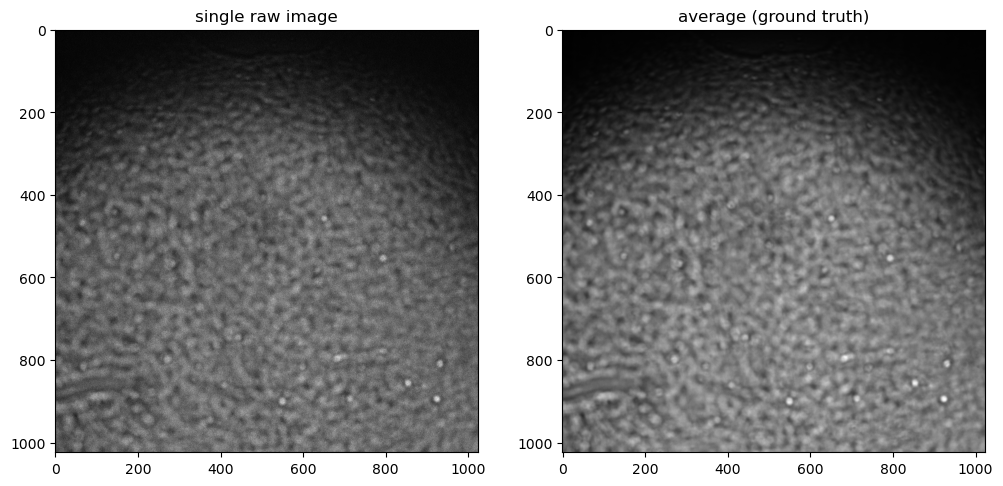

In [5]:
# The data contains 100 images of a static sample.
# We estimate the clean signal by averaging all images.
signal=np.mean(observation,axis=0)[np.newaxis,...]

# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [6]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 305, 2905
bins = 260

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

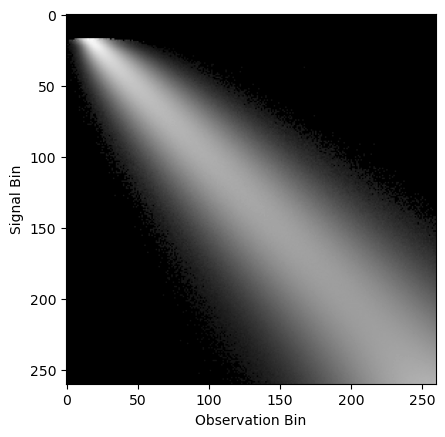

In [7]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 479.68
Maximum Signal Intensity is 5260.34


Iterating the noise model training for `n_epoch=4000`, `batchSize=25000` and `min_sigma` =200 works the best for `Mouse actin` dataset. 

In [9]:
gaussianMixtureNoiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff, min_sigma = 200, device = device)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate=0.1, name = nameGMMNoiseModel)

0 14.561177253723145
100 6.922272205352783
200 6.923866271972656
300 6.924975872039795
400 6.929338455200195
500 6.921630859375
600 6.914294719696045
700 6.91831111907959
800 6.917592525482178
900 6.915173053741455
1000 6.916838645935059
1100 6.919327259063721
1200 6.922214984893799
1300 6.9230523109436035
1400 6.918983459472656
1500 6.913544654846191
1600 6.914015293121338
1700 6.9171552658081055
1800 6.91309118270874
1900 6.920891284942627
2000 6.91562557220459
2100 6.912170886993408
2200 6.917802333831787
2300 6.922466278076172
2400 6.9217071533203125
2500 6.923901081085205
2600 6.910862445831299
2700 6.916341781616211
2800 6.926272869110107
2900 6.911843776702881
3000 6.916514873504639
3100 6.919698715209961
3200 6.92550802230835
3300 6.9248785972595215
3400 6.916046142578125
3500 6.909308433532715
3600 6.925930976867676
3700 6.911655426025391
3800 6.930808067321777
3900 6.919342517852783

The trained parameters (GMMNoiseModel_mouseactin_3_2_calibration) is saved at location: ../..

## Visualize noise model for a specific *signal-bin* 

Below we just visualize our GMM based noise model for any given signal. In addition, we also visualize how our GMM model fits to the true noise model which we create using all calibraton data in the form of histogram

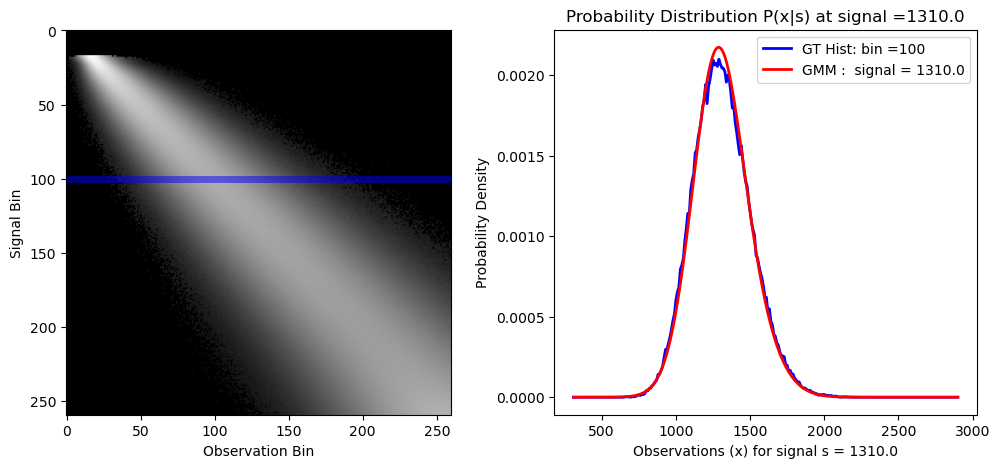

In [10]:
plotProbabilityDistribution(signalBinIndex=100, histogram=histogramFD, gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, max_signal=maxVal, n_bin= bins, device=device)